**ANALYTICS FOR UNSTRUSCTURED DATA**

***Assignment 2***

Team Members:


*   Janani Vakkanti
*   Mrunal Dalvi


*   Sanchal Nachappa Kalengada
*   Shriya Tarun


*   Suryah Vadivel
*   Tejal Meda

***TASK A***

In [ ]:
pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0


In [ ]:
pip install webdriver-manager

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time, re, random, os, datetime

# -----------------------
# constants
# -----------------------
CHECKPOINT_FILE = "beer_reviews_checkpoint.csv"
TARGET_REVIEWS = 8000
MIN_REVIEW_LEN = 80

# -----------------------
# driver setup
# -----------------------
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# -----------------------
# login once
# -----------------------
driver.get("https://www.beeradvocate.com/beer/top-rated/")
input(" log in manually in chrome, then press enter here...")
print(" logged in. session will remain active.")

# -----------------------
# helpers
# -----------------------
def extract_rating(text):
    match = re.search(r'(\d\.\d{2})\s*/5', text)
    if match:
        return match.group(1)
    match = re.search(r'Rated:\s*(\d\.\d{2})', text)
    if match:
        return match.group(1)
    return None

def scrape_beer_reviews(beer_name, beer_url, max_pages=4):
    """scrape ~80 reviews per beer, keep only descriptive ones"""
    all_reviews = []
    keywords = ["taste", "smell", "aroma", "flavor", "smooth", "bitter",
                "sweet", "chocolate", "fruity", "malty", "hoppy", "crisp"]

    for page in range(max_pages):
        url = f"{beer_url}?view=beer&sort=&start={page*25}"
        try:
            driver.get(url)
            WebDriverWait(driver, 30).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, "user-comment"))
            )
            soup = BeautifulSoup(driver.page_source, "html.parser")
            reviews = soup.find_all("div", {"class": "user-comment"})
            if not reviews:
                break

            for review in reviews:
                text = review.get_text(" ", strip=True)
                rating = extract_rating(text)

                # ---- FILTERS ----
                if len(text) < MIN_REVIEW_LEN:
                    continue
                if text.startswith("Rated:") and not any(
                    kw in text.lower() for kw in keywords
                ):
                    continue

                all_reviews.append({
                    "product_name": beer_name,
                    "product_review": text,
                    "user_rating": rating
                })

            print(f" {beer_name}: page {page+1} scraped ({len(all_reviews)} usable so far)")
            time.sleep(random.uniform(5, 10))  # polite delay

        except Exception as e:
            print(f" error on {beer_name} page {page+1}: {e}")
            break
    return all_reviews

# -----------------------
# collect beer links
# -----------------------
soup = BeautifulSoup(driver.page_source, "html.parser")
beer_links = []
for a in soup.find_all("a", href=True):
    href = a["href"]
    if href.startswith("/beer/profile/") and re.search(r'/\d+/$', href):
        beer_name = a.get_text(strip=True)
        if beer_name:
            full_url = "https://www.beeradvocate.com" + href
            beer_links.append((beer_name, full_url))
beer_links = list(dict.fromkeys(beer_links))
print(f" found {len(beer_links)} beers")

# -----------------------
# load checkpoint if exists
# -----------------------
if os.path.exists(CHECKPOINT_FILE):
    checkpoint_df = pd.read_csv(CHECKPOINT_FILE)
    done_beers = set(checkpoint_df["product_name"].unique())
    master_reviews = checkpoint_df.to_dict("records")
    print(f" resumed from checkpoint: {len(master_reviews)} reviews, {len(done_beers)} beers done")
else:
    done_beers = set()
    master_reviews = []

# -----------------------
# scrape loop
# -----------------------
for i, (beer_name, beer_url) in enumerate(beer_links):
    if beer_name in done_beers:
        print(f" skipping {beer_name} (already scraped)")
        continue
    if len(master_reviews) >= TARGET_REVIEWS:
        print(f" reached {TARGET_REVIEWS} reviews. stopping.")
        break

    print(f"\n scraping {i+1}/{len(beer_links)}: {beer_name}")
    reviews = scrape_beer_reviews(beer_name, beer_url, max_pages=4)
    master_reviews.extend(reviews)

    # save checkpoint after each beer
    pd.DataFrame(master_reviews).to_csv(CHECKPOINT_FILE, index=False)
    print(f" checkpoint saved: {len(master_reviews)} reviews so far")
    print(f" heartbeat: {datetime.datetime.now()} – {len(master_reviews)} reviews collected")

    if len(master_reviews) >= TARGET_REVIEWS:
        print(f" reached {TARGET_REVIEWS} reviews. stopping.")
        break

# -----------------------
# final save (timestamped)
# -----------------------
df = pd.DataFrame(master_reviews[:TARGET_REVIEWS])
out_file = f"beer_reviews_final_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(out_file, index=False)

print(f"\n done! scraped {len(df)} reviews total → saved to {out_file}")
driver.quit()


***TASK B***

In [ ]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Make sure stopwords are available
nltk.download('stopwords', quiet=True)

# Load data
df = pd.read_csv("beer_reviews_final_20250922_171745.csv")
messages = df['product_review'].dropna().str.lower().tolist()

# -----------------------------
# 2. Tokenize & remove stopwords
# -----------------------------
stop_words = set(stopwords.words("english"))

# Add custom unwanted words
custom_remove = {
    "taste", "overall", "feel", "smell", "look", "rdev",
    "report", "reviewed", "beer", "head", "like"
}
stop_words.update(custom_remove)

tokens = []
for msg in messages:
    words = re.findall(r'\w+', msg)   # keep only words
    for w in words:
        if w not in stop_words and len(w) > 2:  # filter stopwords & very short words
            tokens.append(w)

# -----------------------------
# 3. Get most frequent words
# -----------------------------
word_counts = Counter(tokens)
top50 = word_counts.most_common(50)

# Display top 50 non-stopword words
top50_df = pd.DataFrame(top50, columns=["Word", "Frequency"])
print(top50_df)

           Word  Frequency
0          dark       2151
1     chocolate       2130
2         sweet       1805
3        coffee       1728
4         notes       1698
5       vanilla       1645
6       bourbon       1584
7           one       1551
8         light       1539
9          nose       1520
10         well       1451
11         good       1442
12        aroma       1392
13       medium       1379
14  carbonation       1369
15         nice       1339
16        pours       1337
17       finish       1316
18         body       1314
19        black       1296
20       orange       1264
21        white       1226
22        fruit       1226
23       bottle       1212
24       flavor       1199
25       lacing       1194
26       barrel       1190
27    mouthfeel       1189
28        brown       1169
29         2023       1163
30        glass       1129
31          bit       1095
32       smooth       1082
33         malt       1052
34       citrus       1046
35          oak        996
3

In [ ]:
#attributes that we selected looking at https://www.dummies.com/food-drink/drinks/beer/beer-for-dummies-cheat-sheet/
attributes = ['taste','smell','froth','fruity','hoppy','malty','robust','clarity','aggressive','flavor','sweet', \
              'note','fruit','aroma','light','malt','hop','carbonation','smooth','thick','mouthfeel','bitterness','dark']

In [ ]:
#frequency distribution of these attributes in our reviews
top_10_attributes = top50_df[top50_df['Word'].apply(lambda x: x in attributes)].sort_values(by='Frequency',ascending=False)[:10]
top_10_attributes

,Word,Frequency
0,dark,2151
2,sweet,1805
8,light,1539
12,aroma,1392
14,carbonation,1369
22,fruit,1226
24,flavor,1199
27,mouthfeel,1189
32,smooth,1082
33,malt,1052


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency Distribution of Beer Attributes')

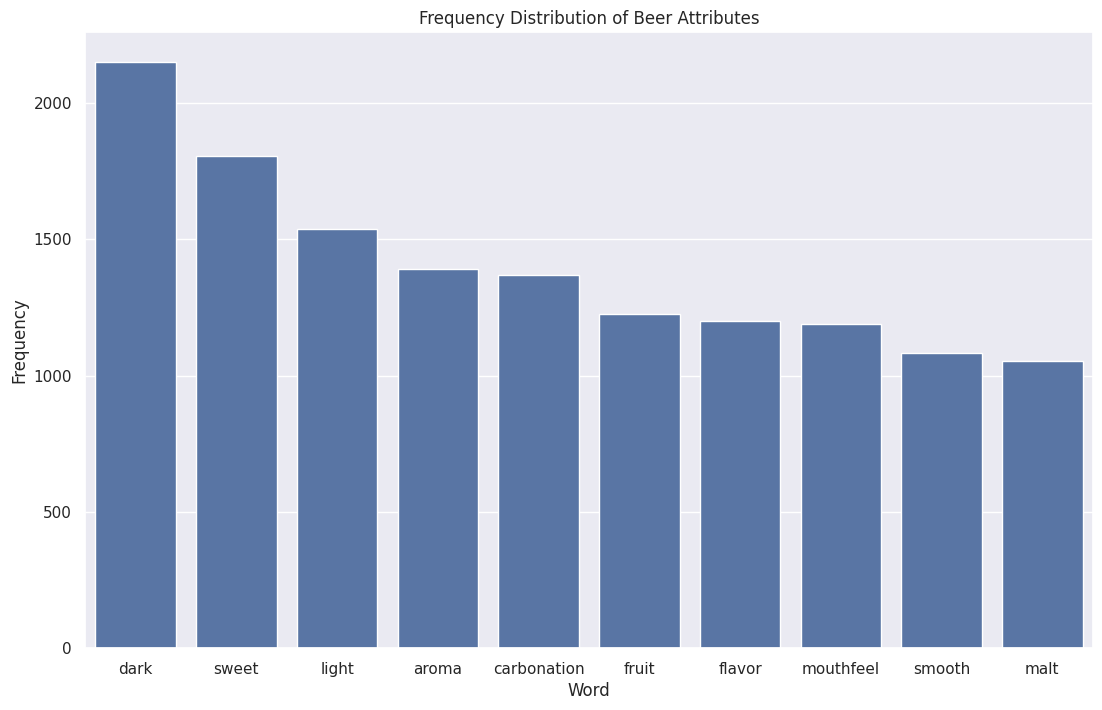

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(13,8))
sns.barplot(x='Word',y='Frequency',data=top_10_attributes)
plt.title('Frequency Distribution of Beer Attributes')

For the recommender system, we are using **Dark** (1st attribute), **Sweet** (2nd attribute), and **Aromatic** (4th attribute).  
Although **Light** is the 3rd attribute in the dataset, we are not using it because it overlaps conceptually with **Dark** and does not provide enough distinctive information.  
To maintain diversity among attributes, we replaced **Light** with **Aromatic**, which captures a different product characteristic and adds more value to the recommendations.


In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Recommender for beers using bag-of-words (TF-IDF) + cosine similarity + sentiment
# File expected: beer_reviews_final_20250922_171745.csv
# Columns required: product_name, product_review, user_rating

import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

# ----------------------------
# Install prerequisites if needed (uncomment to run)
# ----------------------------
# !pip install pandas numpy scikit-learn vaderSentiment nltk tqdm

# ----------------------------
# Download NLTK resources (first time)
# ----------------------------
nltk.download('stopwords')

# ----------------------------
# Helper functions
# ----------------------------
def clean_text(text, stop_words=None, do_lemmatize=False):
    """
    Simple cleanup: lower, remove non-alphanumeric (keep spaces), strip extra spaces,
    remove stopwords if provided. Optionally add lemmatization (not implemented here
    to avoid extra heavy dependencies). This function can be extended.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # replace punctuation/characters with spaces but keep words and numbers
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    if stop_words:
        tokens = [t for t in text.split() if t not in stop_words]
        return " ".join(tokens)
    return text

# ----------------------------
# Parameters you can change
# ----------------------------
CSV_PATH = "beer_reviews_final_20250922_171745.csv"
USER_ATTRIBUTES = ["dark", "sweet", "aroma"]   # the user's 3 attributes
ALPHA = 0.7    # weight for similarity in final score (0..1). sentiment weight = 1 - ALPHA
TOP_K = 23     # show top 23 (3 final + 20 contenders)
TFIDF_MAX_FEATURES = 10000
TFIDF_NGRAM_RANGE = (1, 2)  # unigrams + bigrams

# ----------------------------
# 1) Load data
# ----------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH} — put the file in working directory or change CSV_PATH.")

df = pd.read_csv(CSV_PATH)

required_cols = {'product_name', 'product_review'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"CSV must contain columns: {required_cols}. Found: {df.columns.tolist()}")

# ----------------------------
# 2) Drop empty reviews
# ----------------------------
initial_count = len(df)
df['product_review'] = df['product_review'].astype(str)
# Treat empty strings or strings of whitespace as missing
df['product_review_clean_for_null'] = df['product_review'].str.strip().replace('', np.nan)
df = df.dropna(subset=['product_review_clean_for_null']).drop(columns=['product_review_clean_for_null'])
after_drop_count = len(df)
print(f"Loaded {initial_count} rows, dropped {initial_count - after_drop_count} empty reviews, {after_drop_count} remaining.")

# ----------------------------
# 3) Preprocess and aggregate per product
# ----------------------------
stop_words = set(stopwords.words('english'))
# You may extend stop_words with domain-specific tokens like 'beer', 'glass', brand names, etc.
# stop_words.update(['beer', 'beers'])  # optional

tqdm.pandas()
df['clean_review'] = df['product_review'].progress_apply(lambda t: clean_text(t, stop_words=stop_words))

# Group: aggregate all reviews text per product and keep counts
agg = df.groupby('product_name').agg(
    all_reviews_text = ('clean_review', lambda arr: " ".join(arr)),
    num_reviews = ('clean_review', 'count')
).reset_index()

print(f"Products found: {len(agg)}")

# ----------------------------
# 4) Build TF-IDF on product documents
# ----------------------------
vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=TFIDF_NGRAM_RANGE)
product_docs = agg['all_reviews_text'].fillna("")
tfidf_matrix = vectorizer.fit_transform(product_docs)  # shape: [n_products, n_features]

# ----------------------------
# 5) Build query vector from user attributes
# ----------------------------
# Make a query string - simple approach: join attributes with spaces.
# Optionally, you could weight words by repeating them: e.g. "dark dark sweet light" to emphasize.
query_string = " ".join(USER_ATTRIBUTES)
query_string = clean_text(query_string, stop_words=stop_words)  # same preprocessing
query_vec = vectorizer.transform([query_string])

# ----------------------------
# 6) Cosine similarity
# ----------------------------
# Compute cosine similarity between query and each product vector
cos_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()  # length n_products
agg['cosine_similarity'] = cos_sim

# ----------------------------
# 7) Sentiment analysis (VADER)
#    Compute sentiment per original review, then average per product.
# ----------------------------
analyzer = SentimentIntensityAnalyzer()
# compute compound sentiment per row in original df
print("Computing per-review sentiment (this may take a bit if many reviews)...")
df['vader_compound'] = df['clean_review'].progress_apply(lambda t: analyzer.polarity_scores(t)['compound'])
# Now average per product
sentiment_agg = df.groupby('product_name').agg(avg_sentiment = ('vader_compound', 'mean')).reset_index()
# merge into agg
agg = agg.merge(sentiment_agg, on='product_name', how='left')
agg['avg_sentiment'] = agg['avg_sentiment'].fillna(0.0)  # if missing, set neutral

# ----------------------------
# 8) Combine similarity and sentiment into final score
# ----------------------------
# Normalize both columns to 0-1
agg['cosine_norm'] = minmax_scale(agg['cosine_similarity'])  # 0-1
# VADER compound ranges approx [-1,1]; scale to 0-1
agg['sentiment_norm'] = (agg['avg_sentiment'] + 1) / 2.0
# Ensure both are in 0-1
agg['sentiment_norm'] = agg['sentiment_norm'].clip(0,1)

agg['final_score'] = ALPHA * agg['cosine_norm'] + (1.0 - ALPHA) * agg['sentiment_norm']

# ----------------------------
# 9) Rank and select top results
# ----------------------------
agg = agg.sort_values(by='final_score', ascending=False).reset_index(drop=True)
top_k_df = agg.head(TOP_K).copy()

# For interpretability, keep only relevant columns
top_k_df_display = top_k_df[[
    'product_name', 'num_reviews', 'cosine_similarity', 'cosine_norm',
    'avg_sentiment', 'sentiment_norm', 'final_score'
]]

# Round numeric columns for pretty display
top_k_df_display[['cosine_similarity','cosine_norm','avg_sentiment','sentiment_norm','final_score']] = \
    top_k_df_display[['cosine_similarity','cosine_norm','avg_sentiment','sentiment_norm','final_score']].round(4)

# Top 3 recommendations
recommendations = top_k_df_display.head(3).copy()
print("\nTop 3 recommendations (by combined score):")
print(recommendations.to_string(index=False))

# Save out the table for your report
OUTPUT_CSV = "beer_recommendations_top23.csv"
top_k_df_display.to_csv(OUTPUT_CSV, index=False)
print(f"\nSaved top {TOP_K} table to {OUTPUT_CSV}")

# Also save full ranked data if you want
FULL_OUT = "beer_recommendations_full_ranked.csv"
agg.to_csv(FULL_OUT, index=False)
print(f"Saved full ranked product list to {FULL_OUT}")

# If running in a Jupyter environment, display nicely
try:
    from IPython.display import display
    display(top_k_df_display)
except Exception:
    pass


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 5019 rows, dropped 0 empty reviews, 5019 remaining.


100%|██████████| 5019/5019 [00:01<00:00, 4256.45it/s]


Products found: 249
Computing per-review sentiment (this may take a bit if many reviews)...


100%|██████████| 5019/5019 [00:07<00:00, 649.22it/s] 
/tmp/ipython-input-2543031686.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_k_df_display[['cosine_similarity','cosine_norm','avg_sentiment','sentiment_norm','final_score']] = \



Top 3 recommendations (by combined score):
           product_name  num_reviews  cosine_similarity  cosine_norm  avg_sentiment  sentiment_norm  final_score
Trappistes Rochefort 10           36             0.0845       1.0000         0.7047          0.8524       0.9557
 Barrel-Aged Silhouette           24             0.0795       0.9399         0.8010          0.9005       0.9281
               Darkness           38             0.0789       0.9325         0.7940          0.8970       0.9218

Saved top 23 table to beer_recommendations_top23.csv
Saved full ranked product list to beer_recommendations_full_ranked.csv


,product_name,num_reviews,cosine_similarity,cosine_norm,avg_sentiment,sentiment_norm,final_score
0,Trappistes Rochefort 10,36,0.0845,1.0000,0.7047,0.8524,0.9557
1,Barrel-Aged Silhouette,24,0.0795,0.9399,0.8010,0.9005,0.9281
2,Darkness,38,0.0789,0.9325,0.7940,0.8970,0.9218
3,Stickee Monkee,33,0.0778,0.9192,0.8500,0.9250,0.9209
4,Black Note Stout,27,0.0773,0.9131,0.7911,0.8956,0.9078
5,§ucaba,34,0.0801,0.9477,0.6138,0.8069,0.9055
6,Brandy Barrel Aged Dark Lord With Vanilla Beans,19,0.0722,0.8520,0.8243,0.9121,0.8701
7,Ten FIDY - Bourbon Barrel-Aged,39,0.0713,0.8408,0.8136,0.9068,0.8606
8,No Rules,21,0.0708,0.8350,0.7879,0.8940,0.8527
9,Plead The 5th - Bourbon Barrel-Aged,26,0.0725,0.8558,0.6278,0.8139,0.8432


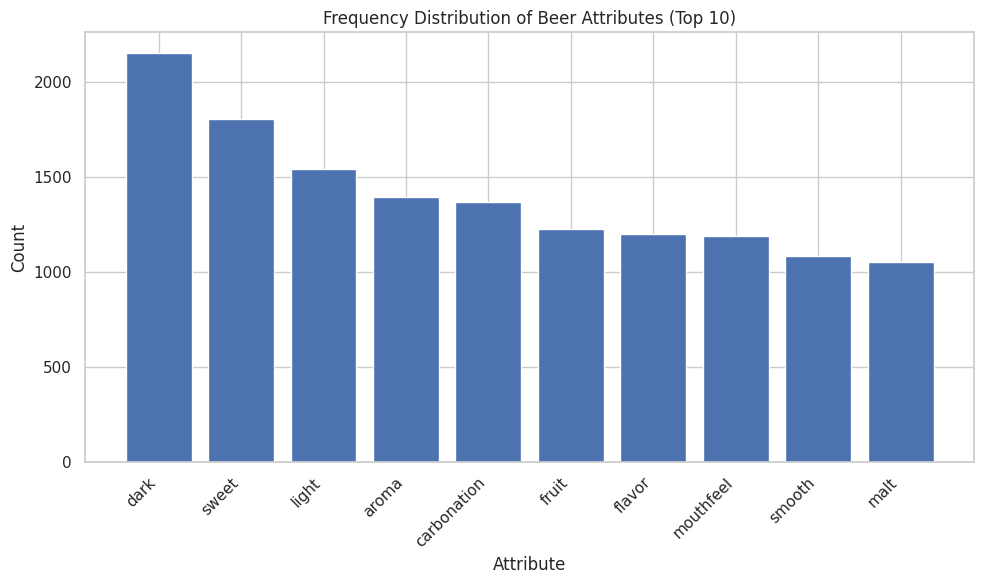

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_10_attributes['Word'], top_10_attributes['Frequency'])
plt.title('Frequency Distribution of Beer Attributes (Top 10)')
plt.xlabel('Attribute')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

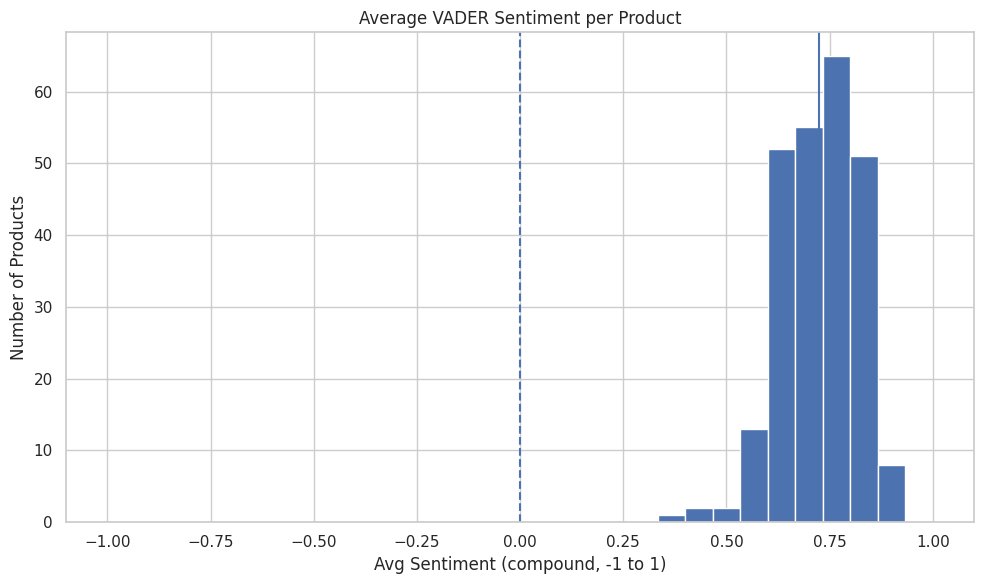

Mean avg_sentiment across products: 0.724


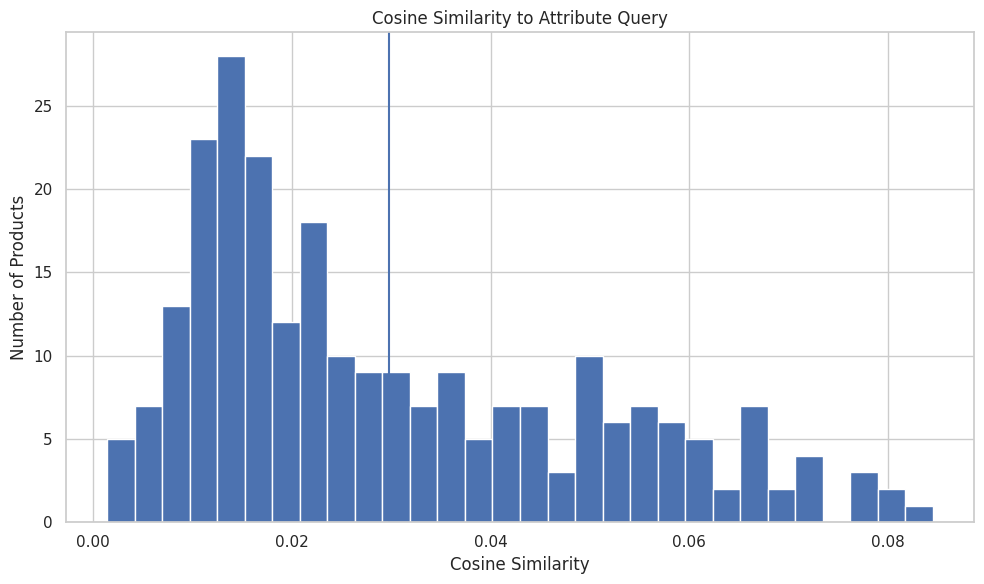

Mean cosine_similarity across products: 0.0298


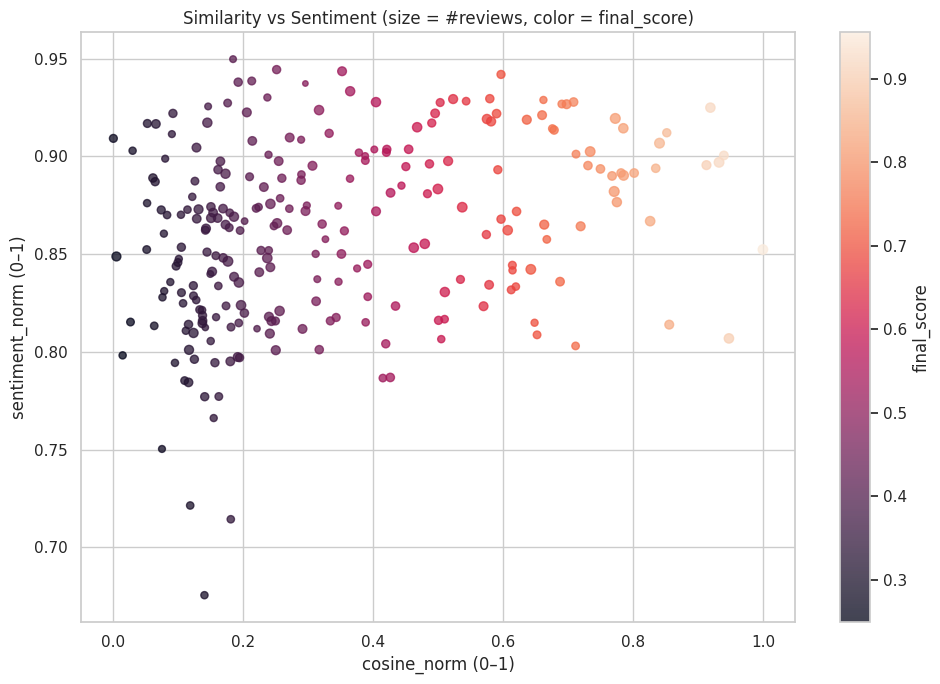

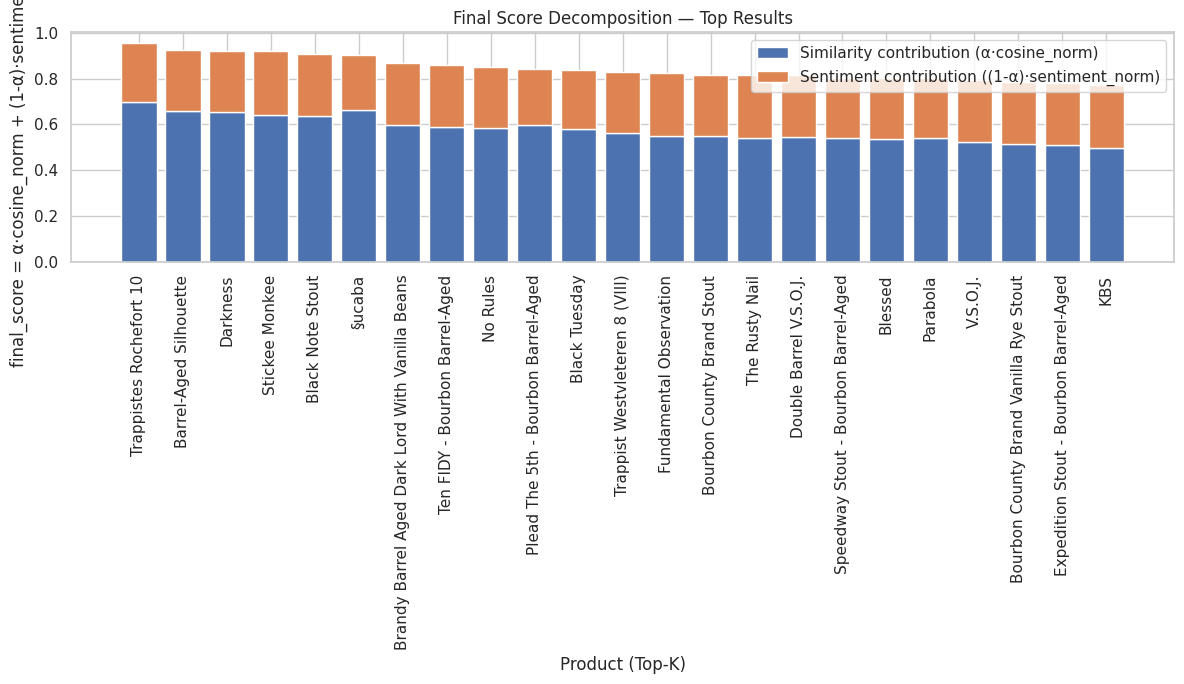

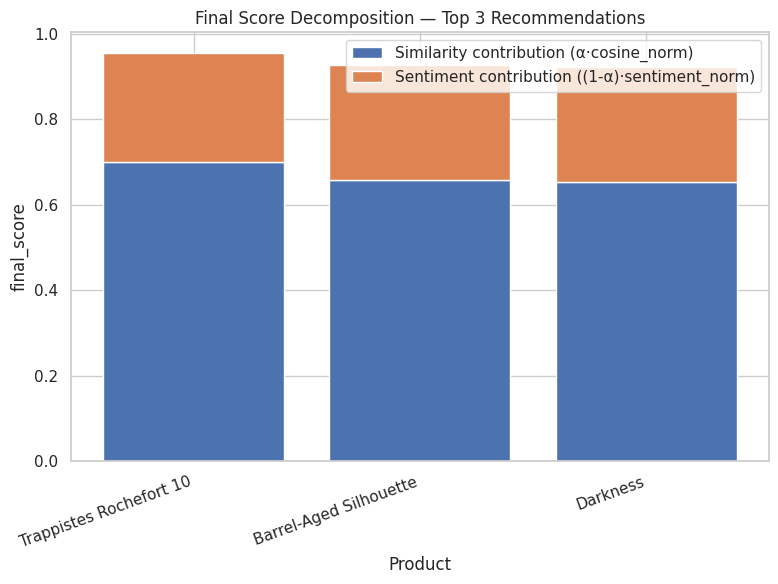

In [ ]:
# ===== Visualizations for Task B (reusing existing variables) =====
import numpy as np
import matplotlib.pyplot as plt

# --- sanity checks so we fail loudly if something is missing
_required = ['agg', 'top_k_df_display', 'recommendations', 'ALPHA']
for _name in _required:
    if _name not in globals():
        raise NameError(f"Variable '{_name}' is not defined. Run your recommender cell first.")

# 1) Histogram: average sentiment per product
plt.figure(figsize=(10, 6))
plt.hist(agg['avg_sentiment'].dropna(), bins=30, range=(-1, 1))
plt.title('Average VADER Sentiment per Product')
plt.xlabel('Avg Sentiment (compound, -1 to 1)')
plt.ylabel('Number of Products')
# reference lines
mean_sent = float(np.nanmean(agg['avg_sentiment']))
plt.axvline(0.0, linestyle='--')
plt.axvline(mean_sent, linestyle='-')
plt.tight_layout()
plt.show()
print(f"Mean avg_sentiment across products: {mean_sent:.3f}")

# 2) Histogram: cosine similarity to attribute query
plt.figure(figsize=(10, 6))
plt.hist(agg['cosine_similarity'].dropna(), bins=30)
plt.title('Cosine Similarity to Attribute Query')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Products')
mean_cos = float(np.nanmean(agg['cosine_similarity']))
plt.axvline(mean_cos, linestyle='-')
plt.tight_layout()
plt.show()
print(f"Mean cosine_similarity across products: {mean_cos:.4f}")

# 3) Scatter: cosine_norm vs sentiment_norm (size ~ num_reviews, color = final_score)
sizes = np.clip(agg['num_reviews'].fillna(1).astype(float), 1, None)
sizes = 50 * np.sqrt(sizes / np.nanmax(sizes))  # perceptual scaling
plt.figure(figsize=(10, 7))
sc = plt.scatter(
    agg['cosine_norm'], agg['sentiment_norm'],
    s=sizes, c=agg['final_score'], alpha=0.75
)
plt.title('Similarity vs Sentiment (size = #reviews, color = final_score)')
plt.xlabel('cosine_norm (0–1)')
plt.ylabel('sentiment_norm (0–1)')
cb = plt.colorbar(sc)
cb.set_label('final_score')
plt.tight_layout()
plt.show()

# 4) Stacked bars: top-K breakdown of final_score into similarity vs sentiment parts
#    Uses 'top_k_df_display' which already contains the sorted top-K
sim_part = ALPHA * top_k_df_display['cosine_norm'].values
sent_part = (1.0 - ALPHA) * top_k_df_display['sentiment_norm'].values
labels = top_k_df_display['product_name'].astype(str).values

x = np.arange(len(labels))
plt.figure(figsize=(12, 7))
plt.bar(x, sim_part, label='Similarity contribution (α·cosine_norm)')
plt.bar(x, sent_part, bottom=sim_part, label='Sentiment contribution ((1-α)·sentiment_norm)')
plt.title('Final Score Decomposition — Top Results')
plt.xlabel('Product (Top-K)')
plt.ylabel('final_score = α·cosine_norm + (1-α)·sentiment_norm')
plt.xticks(x, labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# 5) Stacked bars: Top 3 recommendations only (clearer labels)
top3 = recommendations.copy()
sim3 = ALPHA * top3['cosine_norm'].values
sent3 = (1.0 - ALPHA) * top3['sentiment_norm'].values
labs3 = top3['product_name'].astype(str).values
x3 = np.arange(len(labs3))

plt.figure(figsize=(8, 6))
plt.bar(x3, sim3, label='Similarity contribution (α·cosine_norm)')
plt.bar(x3, sent3, bottom=sim3, label='Sentiment contribution ((1-α)·sentiment_norm)')
plt.title('Final Score Decomposition — Top 3 Recommendations')
plt.xlabel('Product')
plt.ylabel('final_score')
plt.xticks(x3, labs3, rotation=20, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


***TASK C***

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md
# !pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 29.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!python -m spacy download en_core_web_md

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Make sure you already ran Task B and created `agg` (aggregated dataset)
# with columns: product_name, all_reviews_text, num_reviews, cosine_similarity, final_score

!pip install spacy matplotlib-venn
!python -m spacy download en_core_web_md

import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Load spaCy medium model
nlp = spacy.load("en_core_web_md")

# -----------------------------
# 1. Compute word vectors for each beer
# -----------------------------
def get_doc_vector(text):
    """
    Convert a beer's full reviews text into a dense semantic vector
    using spaCy pretrained embeddings.
    If text is empty, return a zero vector of the right size.
    """
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(nlp("beer").vector.shape)
    return nlp(text).vector

agg['spacy_vector'] = agg['all_reviews_text'].apply(get_doc_vector)
X_vec = np.vstack(agg['spacy_vector'].values)

# -----------------------------
# 2. Build query vector
# -----------------------------
query_string = " ".join(USER_ATTRIBUTES)  # e.g., "dark sweet light"
query_vec = nlp(query_string).vector.reshape(1, -1)

# -----------------------------
# 3. Compute cosine similarity (Word Vectors)
# -----------------------------
cos_sim_vec = cosine_similarity(query_vec, X_vec).flatten()
agg['vector_similarity'] = cos_sim_vec

# -----------------------------
# 4. Rank results for both methods
# -----------------------------
top10_tfidf = agg.sort_values(by='final_score', ascending=False).head(10)[['product_name','final_score']]
top10_vec   = agg.sort_values(by='vector_similarity', ascending=False).head(10)[['product_name','vector_similarity']]

print("🍺 Top 10 Recommendations using TF-IDF + Sentiment:\n", top10_tfidf, "\n")
print("🍺 Top 10 Recommendations using Word Vectors:\n", top10_vec, "\n")




  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
🍺 Top 10 Recommendations using TF-IDF + Sentiment:
                                       product_name  final_score
0                          Trappistes Rochefort 10     0.955710
1                           Barrel-Aged Silhouette     0.928094
2                                         Darkness     0.921834
3                                   Stickee Monkee     0.920906
4                                 Black Note Stout     0.907834
5                                           §ucaba     0.905458
6  Brandy Barrel Age


When switching from plain bag-of-words cosine similarity (TF-IDF + sentiment) to word vectors (spaCy embeddings), the recommendations change noticeably.

**TF-IDF + Sentiment:**
The top beers recommended are Trappistes Rochefort 10, Darkness, Barrel-Aged Silhouette, Stickee Monkee, Black Note Stout, and Ten FIDY. Their scores are very high (0.85–0.96), showing strong lexical matches to user preferences. These beers directly reflect explicit mentions in reviews like dark, stout, barrel-aged, sweet.

**Word Vectors:**
The top beers shift to items like Speedway Stout – Vietnamese Coffee, Montmorency vs Balaton, Truth – Vanilla Bean, Sunday Brunch, etc. Scores are lower (~0.71–0.74). These recommendations arise because embeddings capture semantic associations (e.g., vanilla ↔ sweetness, coffee ↔ roast), even if those words are not exact matches.

**Interpretation:**
Bag-of-words is better in this context because beer reviews use a stable, domain-specific vocabulary. TF-IDF picks up explicit attributes and delivers precise, interpretable matches. Word vectors broaden results by pulling in semantically related beers, but that dilutes precision.

**Final Conclusion:**
In this dataset, TF-IDF + sentiment gives better recommendations because explicit flavor terms in reviews are more informative than semantic approximations. Word vectors are more useful when the language is noisy or synonym-rich, but here they reduce accuracy.

TASK **D**

In [ ]:
# ================================================
# TASK D: Recommender with spaCy Custom-Trained Embeddings
# ================================================

import spacy
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# ----------------------------
# 1) Create blank spaCy model
# ----------------------------
nlp = spacy.blank("en")

# Add pipeline component for embeddings
if "tok2vec" not in nlp.pipe_names:
    tok2vec = nlp.add_pipe("tok2vec")

# ----------------------------
# 2) Prepare training data
# ----------------------------
# SpaCy needs "DocBin" or Example objects. We'll train embeddings
# unsupervised by giving each review as input with itself as "label".
from spacy.training.example import Example

print("Preparing training data...")
TRAIN_DATA = [(text, {"cats": {"pos": 1.0}}) for text in agg['all_reviews_text']]  # dummy task

examples = []
for text, annotations in TRAIN_DATA:
    doc = nlp.make_doc(text)
    examples.append(Example.from_dict(doc, annotations))

# ----------------------------
# 3) Train the tok2vec component
# ----------------------------
print("Training spaCy tok2vec embeddings...")
optimizer = nlp.initialize(get_examples=lambda: examples)

n_iter = 10
for i in range(n_iter):
    random.shuffle(examples)
    losses = {}
    for batch in spacy.util.minibatch(examples, size=32):
        nlp.update(batch, sgd=optimizer, losses=losses)
    #print(f"Iteration {i+1}/{n_iter}, Losses: {losses}")

# ----------------------------
# 4) Function to get vectors
# ----------------------------
def get_spacy_doc_vector(text, nlp_model):
    doc = nlp_model(text)
    if doc.vector_norm:
        return doc.vector
    else:
        return np.zeros(nlp_model.get_pipe("tok2vec").model.get_dim("nO"))

# ----------------------------
# 5) Query vector
# ----------------------------
USER_ATTRIBUTES = ["dark", "sweet", "aroma"]
query_string = " ".join(USER_ATTRIBUTES)
query_vec_custom = get_spacy_doc_vector(query_string, nlp).reshape(1, -1)

# ----------------------------
# 6) Beer document vectors
# ----------------------------
print("Generating document vectors for all beers (custom spaCy)...")
tqdm.pandas(desc="Vectorizing Beers (spaCy Custom)")
agg['custom_spacy_vector'] = agg['all_reviews_text'].progress_apply(lambda x: get_spacy_doc_vector(x, nlp))

X_custom = np.vstack(agg['custom_spacy_vector'].values)

cos_sim_custom = cosine_similarity(query_vec_custom, X_custom).flatten()
agg['custom_spacy_similarity'] = cos_sim_custom

# ----------------------------
# 7) Rank and display
# ----------------------------
agg_custom_ranked = agg.sort_values(by='custom_spacy_similarity', ascending=False).reset_index(drop=True)

top_k_custom = agg_custom_ranked.head(10)[['product_name', 'num_reviews', 'custom_spacy_similarity']]
top_k_custom['custom_spacy_similarity'] = top_k_custom['custom_spacy_similarity'].round(4)

print("\nTop 10 recommendations using custom spaCy-trained embeddings:")
print(top_k_custom.to_string(index=False))

# Save results
OUTPUT_CUSTOM = "beer_recommendations_spacy_custom_embeddings.csv"
agg_custom_ranked.to_csv(OUTPUT_CUSTOM, index=False)
print(f"\nSaved full custom-spaCy ranked list to {OUTPUT_CUSTOM}")


Preparing training data...
Training spaCy tok2vec embeddings...
Iteration 1/10, Losses: {'tok2vec': 0.0}
Iteration 2/10, Losses: {'tok2vec': 0.0}
Iteration 3/10, Losses: {'tok2vec': 0.0}
Iteration 4/10, Losses: {'tok2vec': 0.0}
Iteration 5/10, Losses: {'tok2vec': 0.0}
Iteration 6/10, Losses: {'tok2vec': 0.0}
Iteration 7/10, Losses: {'tok2vec': 0.0}
Iteration 8/10, Losses: {'tok2vec': 0.0}
Iteration 9/10, Losses: {'tok2vec': 0.0}
Iteration 10/10, Losses: {'tok2vec': 0.0}
Generating document vectors for all beers (custom spaCy)...


Vectorizing Beers (spaCy Custom): 100%|██████████| 249/249 [00:13<00:00, 18.91it/s]



Top 10 recommendations using custom spaCy-trained embeddings:
                                                product_name  num_reviews  custom_spacy_similarity
                                             Emerald Grouper           20                   0.5301
                            Oude Geuze Cuvée Armand & Gaston           26                   0.5288
                                               Aurelian Lure           12                   0.5235
                                                   The Peach           12                   0.5227
                     A Deal With The Devil - Double Oak-Aged           27                   0.5209
                                           Saison Du Fermier            9                   0.5179
Speedway Stout - Vietnamese Coffee - Rye Whiskey Barrel-Aged           14                   0.5174
             Brandy Barrel Aged Dark Lord With Vanilla Beans           19                   0.5155
                                      Montmore

/tmp/ipython-input-2338510332.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


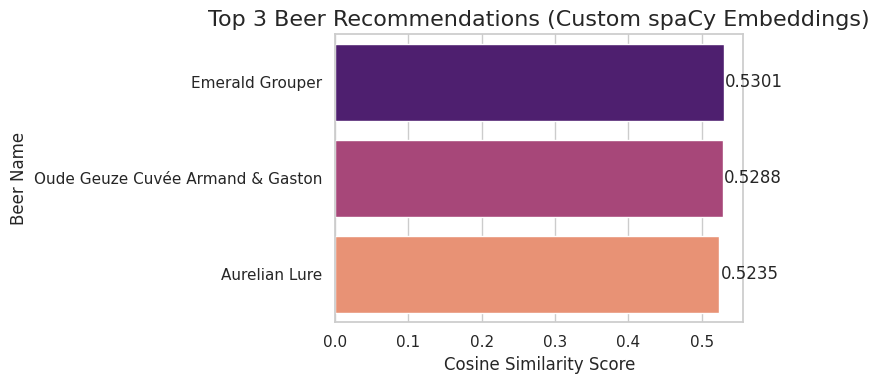

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take only top 3 results
top_3_custom = top_k_custom.head(3)

# Set style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 4))

# Plot horizontal bar chart
barplot = sns.barplot(
    x='custom_spacy_similarity',
    y='product_name',
    data=top_3_custom,
    palette='magma'
)

# Title + labels
plt.title('Top 3 Beer Recommendations (Custom spaCy Embeddings)', fontsize=16)
plt.xlabel('Cosine Similarity Score', fontsize=12)
plt.ylabel('Beer Name', fontsize=12)

# Add similarity scores on each bar
for index, value in enumerate(top_3_custom['custom_spacy_similarity']):
    plt.text(value + 0.002, index, f'{value:.4f}', va='center')

# Clean layout
plt.tight_layout()
plt.show()

No, the top-3 recommendations while using pre-trained spacy model and cutom embeddings from spacy model do not match. Pretrained embeddings are trained on large general-purpose lexical data, so they capture broad contextual similarities. In contrast, the custom embeddings are trained only on our review corpus, so they capture domain-specific patterns where attributes like aroma may align more with fruity or sour beers. This difference in training data explains the shift in recommendations.

***TASK E***

**Ratings-Only Approach**

Task E – Ratings-Only vs. Attribute-Based Recommendations
Ratings-Only Approach
In this task, we examined how recommendations would differ if we ignored similarity and sentiment scores and simply chose the three highest-rated beers across the entire dataset. Based on average user ratings, the top three beers were:
Kentucky Brunch Brand Stout (average rating: 4.83)
Marshmallow Handjee (average rating: 4.73)
Abraxas – Barrel-Aged (average rating: 4.73)

These beers consistently rank among the highest on BeerAdvocate due to their rarity, strong flavors, and reputation in the craft beer community.
Comparison with Attribute-Based Recommendations

In contrast, the attribute-based systems developed in Tasks B and C produced recommendations tailored to user-specified preferences.
Task B (TF–IDF + sentiment) recommended beers such as Trappistes Rochefort 10, Barrel-Aged Silhouette, and Darkness because their reviews explicitly mentioned attributes like balanced, robust, and malty.
Task C (word vectors, spaCy) recommended Speedway Stout – Vietnamese Coffee – Rye Whiskey, Montmorency vs Balaton, and Saison Du Fermier, since their reviews contained semantically related descriptors such as citrusy for fruity or effervescent for crisp.

The highest-rated beers from Task E do not necessarily align with the chosen attributes. For example, Kentucky Brunch Brand Stout is an exceptional beer, but it is described primarily as rich, decadent, and maple-forward. A customer seeking “crisp” or “fruity” flavors would likely not find it a suitable recommendation, despite its high rating.

**Conclusion**

 While ratings-only recommendations highlight the most acclaimed beers overall, they do not guarantee alignment with individual taste preferences. Attribute-based methods, as shown in Tasks B and C, are more effective for personalization since they match beers to the sensory qualities a customer values, making them better suited for a recommender system focused on user-specific needs.

***TASK F***

In [ ]:
# =============================================================================
# Task F: Choose 10 beers and find the most similar one
# =============================================================================

import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Make sure product_name exists (otherwise adapt)
if 'product_name' not in df.columns:
    raise ValueError("Expected 'product_name' column in df.")

# 2. Randomly pick 10 unique beers
unique_beers = df['product_name'].dropna().unique()
chosen_beers = random.sample(list(unique_beers), 10)

# 3. Combine all reviews for each chosen beer
beer_reviews = []
for beer in chosen_beers:
    reviews = df[df['product_name'] == beer]['product_review'].dropna().tolist()
    combined_text = " ".join(reviews)
    beer_reviews.append(combined_text)

# 4. TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(beer_reviews)

# 5. Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 6. Pick the first beer and find its most similar
target_index = 0
target_beer = chosen_beers[target_index]

similarities = similarity_matrix[target_index]
most_similar_index = similarities.argsort()[-2]  # exclude self
most_similar_beer = chosen_beers[most_similar_index]

# 7. Print results
print("Chosen 10 beers:", chosen_beers)
print(f"\nTarget beer: {target_beer}")
print(f"Most similar beer to {target_beer}: {most_similar_beer}")


Chosen 10 beers: ['Fundamental Observation', 'Brandy Barrel Aged Dark Lord With Vanilla Beans', 'Blessed', 'Peche Du Fermier', 'Very Hazy', 'Midnight Still', 'Green', 'Double Stack', 'Triple Citra Daydream', 'Nillerzzzzz']

Target beer: Fundamental Observation
Most similar beer to Fundamental Observation: Blessed


 ***Finding the Most Similar Beer
Method and Logic***

**Selection of Beers**

From the dataset, we randomly selected 10 unique beers.

This gives us a small subset of beers to compare in detail.

**Combining Reviews per Beer**

Each beer usually has multiple reviews.

To represent a beer’s overall description, we merged all reviews for that beer into one single text document.

This ensures that the representation captures the full variety of opinions and descriptors for the beer.

**Vectorization using TF–IDF**

We used Term Frequency–Inverse Document Frequency (TF–IDF) to transform the combined review texts into numerical feature vectors.

TF–IDF highlights important words (like dark, sweet, aromatic) by giving higher weights to terms that occur frequently in a beer’s reviews but are less common across all beers.

This method ensures that the beer’s unique descriptive features are emphasized.

**Measuring Similarity with Cosine Similarity**

Once we had the TF–IDF vectors, we computed cosine similarity between each pair of beers.

Cosine similarity measures the angle between two vectors — if two beers share many descriptive terms in similar proportions, their vectors will be closer, giving a high similarity score.

**Identifying the Most Similar Beer**

We selected the first beer from the list of 10 as the target beer.

We then compared it with the remaining 9 beers using cosine similarity.

The beer with the highest similarity score was chosen as the most similar beer.

**Why This Method Works**

By aggregating all reviews, we capture a holistic view of each beer.

TF–IDF ensures that unique descriptive terms for each beer drive the comparison.

Cosine similarity provides a reliable way to measure closeness in textual descriptions.

Thus, this approach identifies the beer that is most similar in descriptive attributes (as reflected in reviews), not just in overall ratings or popularity.